## Import libraries

In [1]:
# Numeric
import numpy as np
import pandas as pd


# Tools
import os, sys
import re
import string
import csv
import itertools


# Natural language processing
import spacy

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as sw
from nltk.stem.snowball import SnowballStemmer


# Preprocessing and Features engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA



# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering



# Classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline



# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


# Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline



## Some utility functions

In [2]:
def print_i_th_review(data, text_column, index):
    """Print the i-th review"""
    print(f"Review: {data.loc[index, text_column]}")
    print()
    print(f"Class: {data.loc[index, 'class']}")

In [3]:
def print_score(scores, type_of_score):
    """Pritn the evaluated scores, their mean and standard deviation."""
    print(f"{type_of_score} for each iteration: {scores}")
    mean = scores.mean()
    std = scores.std() * 2
    print(f"{type_of_score} (statistics): {mean:.3f} (+/- {std:.3f})")

In [4]:
def print_top_n_words(data, text_column, n, save_image=False):
    """Plot the top n words in the pandas"""
    elements = pd.Series(" ".join(data[text_column]).lower().split()).value_counts()

    top_n = n
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(elements.index[:top_n], elements[:top_n], align='center')
    ax.set_title(f"Most frequent {top_n} words")
    plt.gca().invert_yaxis()
    
    if save_image == True:
        fig.savefig('Images/dataExploration')
    
    plt.show()

In [5]:
def write_to_file(filename, labels):
    """Write the evaluated labels to a CSV file."""
    with open(filename, mode='w', encoding='UTF-8') as f:
        fwriter = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        fwriter.writerow(["Id", "Predicted"])
        for Id, label in enumerate(labels):
            fwriter.writerow([Id, label])

## Read data

In [6]:
directory = "/Users/lpdef/Desktop/Polito/Data Science lab process and methods/Final Exam/dataset_winter_2020/"
dataset = pd.read_csv(directory + "development.csv")
testset = pd.read_csv(directory + "evaluation.csv")

print(dataset.iloc[:,0].size)
dataset.head()

28754


,text,class
0,Non è l'hotel più lussuoso in cui abbia mai so...,pos
1,Siamo stati qui per 1 notte prima della nostra...,pos
2,Hotel è ben posizionato per visitare Torino. A...,pos
3,All'arrivo la cordialità e disponibilità dello...,pos
4,Abbiamo soggiornato per due notti alla fine de...,pos


In [7]:
pos = dataset.loc[(dataset['class']=='pos'),:].shape[0]
neg = dataset.loc[(dataset['class']=='neg'),:].shape[0]
print(f"The ratio between the number of positive and negative reviews is: {pos/neg: .2f}")

The ratio between the number of positive and negative reviews is:  2.12


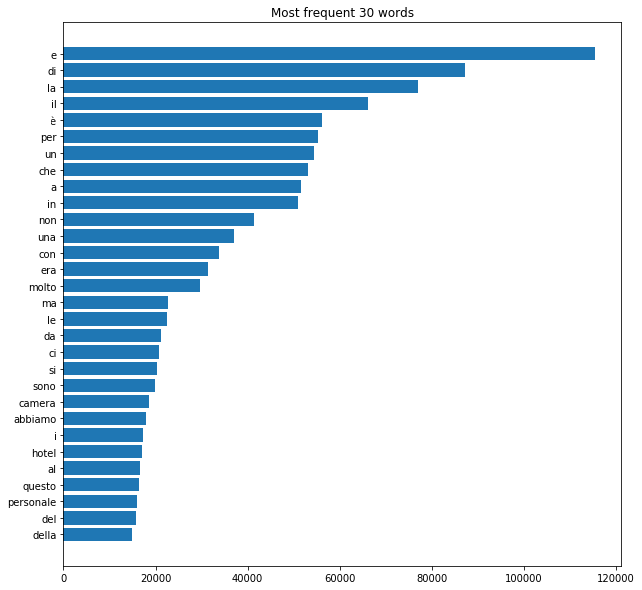

In [8]:
print_top_n_words(dataset, 'text', 30, save_image=True)

In [9]:
print_i_th_review(dataset, 'text', 24)

Review: Albergo molto bello, non si può dire lo stesso della vista su molo beverello. Non tutto il personale è meritevole di un buon giudizio. La stanza puzzava molto di fumo di sigaretta, non appena l'abbiamo evidenziato alla ragazza che ci accompagnati ha esclamato' forse ha fumato una sigaretta prima di entrare ,  il ragazzo che portava le valigie. Volete accertarvi prima?  Prima di cena abbiamo ordinato un aperitivo, tra l'altro incluso nel pacchetto, abbiamo atteso circa 30 minuti il barmann che chiacchierava con altri ospiti, senza curarsi di noi, abbiamo sollecitato considerata la prenotazione per cena in un altro ristorante.La cosa più sgradevole? Il giorno in cui dovevamo lasciare la stanza alle 11:50 ( orario previsto check out 12:00) squilla il telefono per dire che avremmo dovuto lasciare la stanza NB stavamo per uscire . Assurdo se paghi quasi 400 euro. Per il resto qualcuno gentile c'era, come le ragazze della colazione e della spa.

Class: pos


In [10]:
X_train = dataset.iloc[:,0]
y_train = dataset.iloc[:, 1]

## Features engineering

In [11]:
nlp = spacy.load("it_core_news_sm", disable=["ner", "parser", "tagger", "textcat"])
# spacy_stopWords = spacy.lang.it.stop_words.STOP_WORDS

In [12]:
stopWords = sw.words('italian')
stopWords.remove('ma')
# stopWords.remove('molt')
stopWords.remove('non')

stopWords.extend([   
                   # Months
#                    'gennai', 'febbrai', 'marz', 'april', 'magg', 'giugn', 'agost', 'settembr', 'ottobr', 'novembr', 'dicembr',

                 # Warning-generated and misspelled stopwords
                   'avra', 'avro', 'aver', 'com', 'contr', 'esser', 'fac', 'facc', 'far', 'foss','lor',
                   'nostr', 'perc', 'qual', 'quant', 'quell', 'quest', 'sar', 'star', 'stess','tutt',
                   'vostr', 'dar',
                   'hotel',
    
                    # Some common names
#                    'lorenz', 'anna', 'marc', 'francesc',
    
                    # Exclude the days of the week
                   'luned','marted','mercoled','gioved','venerd','sabat','domenic',
                 ]) 



In [13]:

minDF = 0.0005
maxDf = 0.80


class LemmaTokenizer(object):
    
    def __init__(self):
        self.lemmatizer = spacy.load("it_core_news_sm", disable=["ner", "parser", "tagger", "textcat"])
        self.Stemmer = SnowballStemmer("italian")
        
        
    def __call__(self, document):
        lemmas = []
        re_digit = re.compile("[0-9]+")
        document = document.replace("'", " ")

        for t in self.lemmatizer(document):
            if not re_digit.match(t.lemma_):
                t = t.lemma_.strip()
                t = t.translate(str.maketrans('', '', string.punctuation))
                
                if bool(t.isalpha())==True and len(t) > 1 and len(t) <= 16:
                    t = self.Stemmer.stem(t)
                    lemmas.append(t)

        
            
        return lemmas


lemmaTokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer, stop_words=stopWords, min_df=minDF, max_df=maxDf,
                             strip_accents='unicode', lowercase=True, ngram_range=(1,3), sublinear_tf=True)


In [14]:
vectorizer.fit(X_train)

/Users/lpdef/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dio', 'fec', 'neo', 'piu', 'stemm', 'stetter'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=None,
                min_df=0.0005, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl',
                            'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal',
                            'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla',
                            'dalle', 'di', 'del', 'dello', 'dei', 'degli',
                            'dell', 'degl', 'della', 'delle', ...],
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.LemmaTokenizer object at 0x1a2d7deb10>,
                use_idf=True, vocabulary=None)

In [15]:
# print(len(vectorizer.get_feature_names()))
#21939
#21929
#21940
#21149

In [16]:
X_train = vectorizer.transform(X_train)
print(len(vectorizer.get_feature_names()))

21149


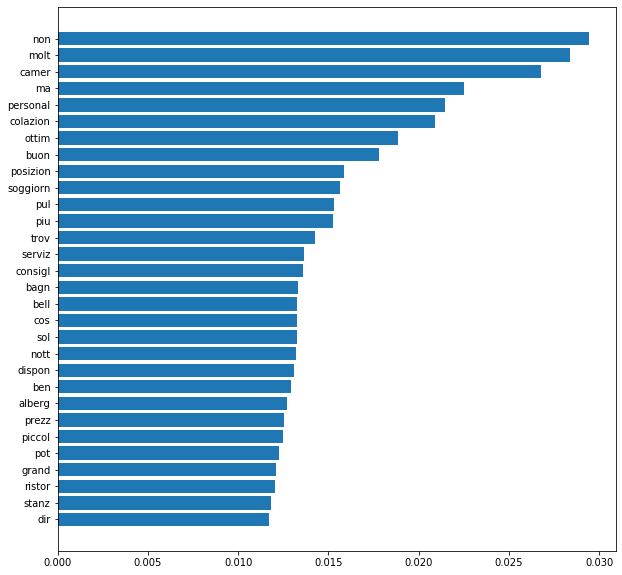

In [17]:
words = np.array(vectorizer.get_feature_names())
weigths = X_train.toarray().mean(axis = 0)
sorted_index = np.argsort(weigths)[::-1]


fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(words[sorted_index[:30]], weigths[sorted_index[:30]], align='center')
plt.gca().invert_yaxis()
plt.show()

### Dimensionality reduction

In [18]:
svd = TruncatedSVD(n_components=2000)
Red_X = svd.fit_transform(X_train)


##  Model selection and cross validation

### Support vector Machines

In [19]:
SVM_model = LinearSVC(penalty="l2", loss="hinge", C=1 , fit_intercept= False)

type_of_score = "f1_weighted"

cv_scores = cross_val_score(SVM_model, Red_X, y_train, cv=5, scoring=type_of_score, n_jobs=-1)

print_score(cv_scores, type_of_score)

f1_weighted for each iteration: [0.96796948 0.97015927 0.9610041  0.9653538  0.9677533 ]
f1_weighted (statistics): 0.966 (+/- 0.006)


### Logistic regression

In [20]:
logReg_model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept=False,
                                      C=8, penalty='l2',max_iter=500)

type_of_score = "f1_weighted"

cv_scores = cross_val_score(logReg_model, Red_X, y_train, cv=5, scoring=type_of_score, n_jobs=-1)

print_score(cv_scores, type_of_score)

f1_weighted for each iteration: [0.96850776 0.97000515 0.96150103 0.96377896 0.9677533 ]
f1_weighted (statistics): 0.966 (+/- 0.006)


## Training and prediction

In [21]:
X_test = vectorizer.transform(testset.iloc[:,0])
Red_X_test = svd.fit_transform(X_test)


In [22]:
logReg_model.fit(Red_X, y_train)
y_pred_test = logReg_model.predict(Red_X_test)
testset.shape

(12323, 1)

In [23]:
y_pred = logReg_model.predict(Red_X)

conf_mat = confusion_matrix(y_train, y_pred)

Index= [['Actual', 'Actual'],['Pos', 'Neg']]
Cols = [['Predicted', 'Predicted'],['Pos', 'Neg']]

df = pd.DataFrame(conf_mat, index=Index, columns=Cols)

df.style.background_gradient(cmap='Reds')

## Writing the results

In [24]:
write_to_file("Labels2.csv", y_pred_test)